In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if 'module_path' not in sys.path:
    sys.path.append(module_path)

import numpy as np
import nibabel as nib
import neurolang as nl
from typing import AbstractSet, Callable
from neurolang.CD_relations import *
from neurolang.frontend import *
from neurolang.regions import *
from neurolang.region_solver import *
from neurolang.symbols_and_types import TypedSymbolTable

%matplotlib inline

### Load a subject's brain imaging data:

In [2]:
subject = '100206'
t1w_path = '../data/%s/T1w/T1w_acpc_dc_restore_brain.nii.gz' % subject
labels_path = '../data/%s/T1w/aparc.a2009s+aseg.nii.gz' % subject
labeled_im = nib.load(labels_path)
t1w_im = nib.load(t1w_path)
type(labeled_im)

nibabel.nifti1.Nifti1Image

### Basic plotting of the subject data:

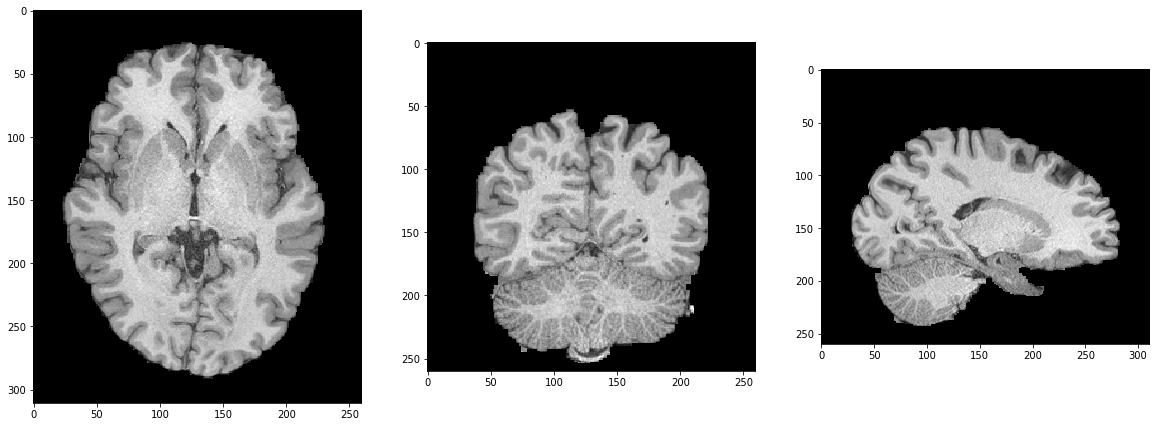

In [3]:
import matplotlib.pyplot as plt
img_data = t1w_im.get_data()

fig = plt.figure(figsize = (20, 20)) 
plt.subplot(1, 3, 1)
plt.imshow(np.rot90(img_data[:,:,100]),cmap = plt.cm.gray,interpolation = 'nearest')
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(img_data[:,100,:]),cmap = plt.cm.gray,interpolation = 'nearest')
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(img_data[100,:,:]),cmap = plt.cm.gray,interpolation = 'nearest')

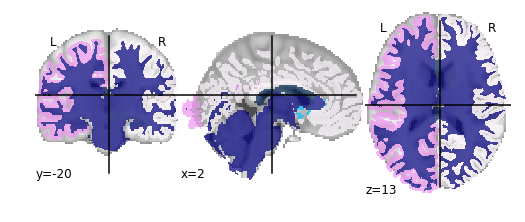

In [4]:
from nilearn import plotting
plotting.plot_roi(labeled_im)

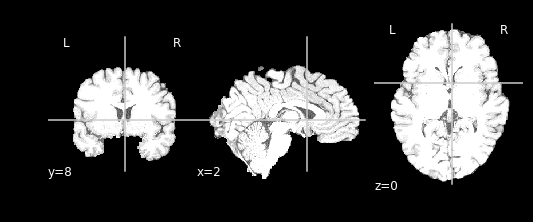

In [5]:
from nilearn.plotting import plot_anat, plot_epi, plot_roi
plot_anat(t1w_im,dim=-1)

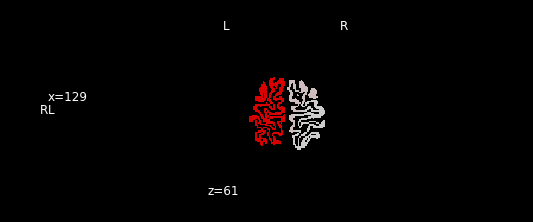

In [6]:
cut_coords = [129, 141, 61]
plot_epi(labeled_im,cut_coords=cut_coords,display_mode='ortho')

### Parse regions from subject parcellation:

In [7]:
from xml.etree import ElementTree
extension_header = ElementTree.fromstring(labeled_im.header.extensions[0].get_content())

labeltable = {
    l.text: int(l.get('Key'))
    for l in extension_header.findall(".//Label")
}
labels = labeled_im.get_data()

### Plot a specific region masked over the T1w image:

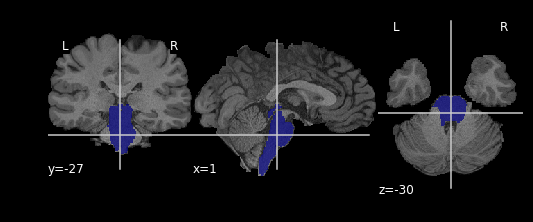

In [8]:
brain_stem_voxels = np.transpose((labels == labeltable['BRAIN-STEM']).nonzero())

brain_stem = ExplicitVBR(brain_stem_voxels,t1w_im.affine, t1w_im.shape)
plotting.plot_roi(brain_stem.spatial_image(),t1w_im)

### Define a specific region from a coordinate: 

In [9]:
brain_stem_coords = nib.affines.apply_affine(labeled_im.affine, brain_stem_voxels)
center = brain_stem_coords[int(brain_stem_coords.shape[0] / 2)]
radius = 5
sr = SphericalVolume(center, radius)
sphere_voxels = sr.to_ijk(t1w_im.affine)
isinstance(sr, ImplicitVBR)

True

### Load labeled regions as symbols into the solver:

In [10]:
# def region_from_label(solver,label):
#     return get_singleton_element_from_frozenset(solver.symbol_table[label].value)

def define_region_from_parcellation_to_solver(region_name, labeled_im=labeled_im):
    extension_header = ElementTree.fromstring(labeled_im.header.extensions[0].get_content())

    labeltable = {
        l.text: int(l.get('Key'))
        for l in extension_header.findall(".//Label")
    }
    labels = labeled_im.get_data()
    region_voxels = np.transpose((labels == labeltable[region_name]).nonzero())
    region = ExplicitVBR(region_voxels, labeled_im.affine, t1w_im.shape)
    region_solver.symbol_table[nl.Symbol[region_solver.type](region_name)] = nl.Constant[
        AbstractSet[region_solver.type]
    ](frozenset([region]))
    
def get_singleton_element_from_frozenset(fs):
    return next(iter(fs))    

set_type = AbstractSet[Region]
region_solver = RegionsSetSolver(TypedSymbolTable())

In [11]:
load_parcellation_regions_to_solver(region_solver, labeled_im, 3)
regions = [k.name for k, v in region_solver.symbol_table.symbols_by_type(set_type).items()]
reference_region = regions[0]
len(regions), regions
for region in regions:
    r = region_from_symbol_name(region_solver, region)
    print(r.bounding_box)
    print(r.aabb_tree.height)

AABB(lb=(-27.599997997283936, -35.700001537799835, -6.200001120567322), up=(0.40000152587890625, 2.099997818470001, 18.999998450279236))
17
AABB(lb=(-4.499998390674591, -88.90000063180923, -25.10000079870224), up=(22.10000115633011, -28.700001657009125, 10.599998593330383))
18
AABB(lb=(-55.59999752044678, -66.50000101327896, 12.699998557567596), up=(-43.69999772310257, -53.90000122785568, 39.99999809265137))
14


### Perform a query over regions:

In [12]:
#pairs of (relation, region) that return empty set:
#anterior_of CTX_RH_G_AND_S_TRANSV_FRONTOPOL
#superior_of CTX_RH_G_AND_S_PARACENTRAL
#inferior_of BRAIN-STEM
#posterior_of CTX_LH_POLE_OCCIPITAL
#left_of CTX_LH_G_TEMP_SUP-LATERAL
#right_of CTX_RH_G_TEMP_SUP-LATERAL
obtained = query_relation_region(region_solver, 'superior_of', reference_region)
print(len(obtained), obtained)

1 ['CTX_LH_S_INTERM_PRIM-JENSEN']


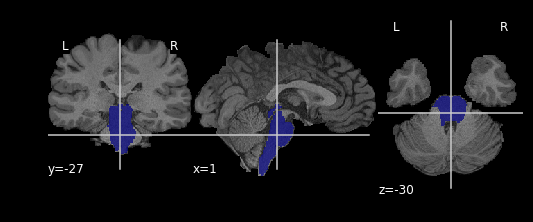

In [13]:
define_region_from_parcellation_to_solver('BRAIN-STEM', labeled_im)
brain_stem = region_from_symbol_name(region_solver, 'BRAIN-STEM')
plotting.plot_roi(brain_stem.spatial_image(),t1w_im)

In [14]:
define_region_from_parcellation_to_solver('LEFT-INF-LAT-VENT', labeled_im)
vbr = get_singleton_element_from_frozenset(region_solver.symbol_table['LEFT-INF-LAT-VENT'].value)

In [15]:
import time

def measure_time(func):
    t0 = time.time()
    res = func()
    duration = time.time() - t0
    print('Done in %fs' % duration)
    return res

In [16]:
define_region_from_parcellation_to_solver('LEFT-CEREBELLUM-CORTEX')
query_relation_region(region_solver, 'overlapping', 'LEFT-CEREBELLUM-CORTEX')

KeyboardInterrupt: 

In [17]:
define_region_from_parcellation_to_solver('CTX_LH_S_PRECENTRAL-SUP-PART', labeled_im)
define_region_from_parcellation_to_solver('CTX_LH_G_PRECENTRAL', labeled_im)
vbr = get_singleton_element_from_frozenset(region_solver.symbol_table['CTX_LH_S_PRECENTRAL-SUP-PART'].value)
other_vbr = get_singleton_element_from_frozenset(region_solver.symbol_table['CTX_LH_G_PRECENTRAL'].value)

voxels = set(map(tuple, vbr.voxels))
other_voxels = set(map(tuple, other_vbr.voxels))

print(voxels.intersection(other_voxels))

set()


In [18]:
define_region_from_parcellation_to_solver('BRAIN-STEM', labeled_im)
vbr = get_singleton_element_from_frozenset(region_solver.symbol_table['BRAIN-STEM'].value)
t1w_im.affine

set(map(tuple, vbr.to_ijk(vbr.affine).tolist()))

{(115.0, 155.0, 57.0),
 (131.0, 116.0, 19.0),
 (116.0, 147.0, 56.0),
 (130.0, 130.0, 78.0),
 (117.0, 122.0, 32.0),
 (114.0, 164.0, 65.0),
 (144.0, 146.0, 81.0),
 (128.0, 147.0, 71.0),
 (123.0, 149.0, 79.0),
 (135.0, 130.0, 74.0),
 (150.0, 153.0, 75.0),
 (133.0, 119.0, 24.0),
 (127.0, 156.0, 61.0),
 (115.0, 124.0, 48.0),
 (136.0, 141.0, 77.0),
 (140.0, 132.0, 38.0),
 (139.0, 129.0, 62.0),
 (116.0, 125.0, 47.0),
 (116.0, 150.0, 63.0),
 (110.0, 130.0, 58.0),
 (113.0, 148.0, 68.0),
 (125.0, 137.0, 46.0),
 (132.0, 151.0, 60.0),
 (120.0, 139.0, 73.0),
 (124.0, 138.0, 38.0),
 (141.0, 143.0, 48.0),
 (131.0, 146.0, 52.0),
 (122.0, 143.0, 69.0),
 (143.0, 141.0, 81.0),
 (130.0, 146.0, 41.0),
 (139.0, 138.0, 59.0),
 (119.0, 154.0, 56.0),
 (137.0, 126.0, 31.0),
 (129.0, 151.0, 49.0),
 (142.0, 145.0, 65.0),
 (118.0, 157.0, 48.0),
 (144.0, 148.0, 77.0),
 (125.0, 142.0, 43.0),
 (123.0, 126.0, 47.0),
 (138.0, 134.0, 40.0),
 (137.0, 141.0, 67.0),
 (109.0, 135.0, 52.0),
 (115.0, 126.0, 68.0),
 (124.0, 14

In [19]:
define_region_from_parcellation_to_solver('CTX_RH_G_TEMP_SUP-LATERAL', labeled_im)
ctx_rh = get_singleton_element_from_frozenset(region_solver.symbol_table['CTX_RH_G_TEMP_SUP-LATERAL'].value)
eigs = np.linalg.eigvals(ctx_rh.affine)[:-1]
resolution = abs(eigs) / 2
print(eigs)
wdt = ctx_rh.width

cant = (wdt // resolution).astype(int)
lb, ub = ctx_rh.bounding_box.lb, ctx_rh.bounding_box.ub
lsp_x = np.linspace(lb[0], ub[0], cant[0])
lsp_y = np.linspace(lb[1], ub[1], cant[1])
lsp_z = np.linspace(lb[2], ub[2], cant[2])

[px, py, pz] = np.meshgrid(lsp_x, lsp_y, lsp_z)
points = np.vstack(map(np.ravel, np.meshgrid(lsp_x, lsp_y, lsp_z)))
points.shape
print(92*198*140, len(ctx_rh.to_xyz()))

[-0.69999999  0.69999999  0.69999999]
2550240 21921


In [20]:
brain_stem = region_from_symbol_name(region_solver,'BRAIN-STEM')
region_solver.symbol_table[nl.Symbol[region_solver.type]('SPHERE')] = nl.Constant[AbstractSet[region_solver.type]](frozenset([sr]))
obtained = query_relation_region(region_solver, 'overlapping', 'SPHERE')
print(len(obtained), obtained)


ov_1 =  cardinal_relation(brain_stem, sr, 'O', refine_overlapping=False)
i = 6
ov_2 = cardinal_relation(brain_stem, sr, 'O', refine_overlapping=True, stop_at=i)
'after {} levels of refinement the overlapping changed from {} to {}'.format(i, ov_1, ov_2)

1 ['BRAIN-STEM']


'after 6 levels of refinement the overlapping changed from True to True'

### Example case for  union of regions 

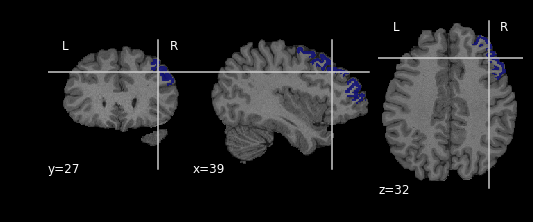

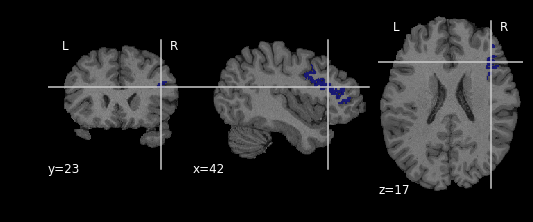

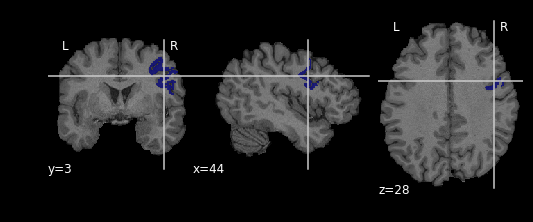

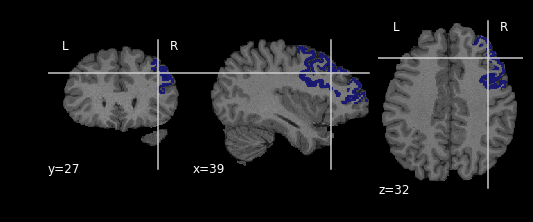

In [21]:
define_region_from_parcellation_to_solver('CTX_RH_G_FRONT_MIDDLE', labeled_im)
define_region_from_parcellation_to_solver('CTX_RH_S_FRONT_INF', labeled_im)
define_region_from_parcellation_to_solver('CTX_RH_S_PRECENTRAL-INF-PART', labeled_im)

r1 = region_from_symbol_name(region_solver,'CTX_RH_G_FRONT_MIDDLE')
r2 = region_from_symbol_name(region_solver,'CTX_RH_S_FRONT_INF')
r3 = region_from_symbol_name(region_solver,'CTX_RH_S_PRECENTRAL-INF-PART')
fs = set().union([r1, r2, r3])
union = region_union(fs, labeled_im.affine)

plotting.plot_roi(r1.spatial_image(), t1w_im) 
plotting.plot_roi(r2.spatial_image(), t1w_im) 
plotting.plot_roi(r3.spatial_image(), t1w_im) 
plotting.plot_roi(union.spatial_image(), t1w_im, cut_coords=[39, 27, 32])

### Brain stem and sphere difference

In [25]:
sphere = region_from_symbol_name(region_solver,'SPHERE')
brain_stem = region_from_symbol_name(region_solver,'BRAIN-STEM')
fs = set().union([brain_stem, sphere])
diff = region_difference(fs, t1w_im.affine)
diff
#plotting.plot_roi(diff.spatial_image(), t1w_im, cut_coords=[39, 27, 32])

Region(VBR= affine:[[  -0.69999999    0.            0.           90.        ]
 [   0.            0.69999999    0.         -126.        ]
 [   0.            0.            0.69999999  -72.        ]
 [   0.            0.            0.            1.        ]], voxels:[[131 116  19]
 [116 147  56]
 [144 146  81]
 ...
 [129 115  17]
 [128 142  53]
 [140 159  70]])

In [26]:
# d1 = region_difference([brain_stem, sphere], t1w_im.affine)
# d2 = region_difference([sphere, brain_stem], t1w_im.affine)
# union = region_union([brain_stem, sphere], t1w_im.affine)
# i1 = region_difference([union, d1, d2], t1w_im.affine)
# i2 = region_intersection([sphere, brain_stem], t1w_im.affine)


# plotting.plot_roi(d1.to_ijk(t1w_im.affine).spatial_image(), t1w_im, cut_coords=[1, -28, -43]) 
# plotting.plot_roi(d2.spatial_image(), t1w_im, cut_coords=[1, -28, -43]) 
# plotting.plot_roi(i2.spatial_image(), t1w_im, cut_coords=[1, -28, -43])

AttributeError: 'numpy.ndarray' object has no attribute 'spatial_image'

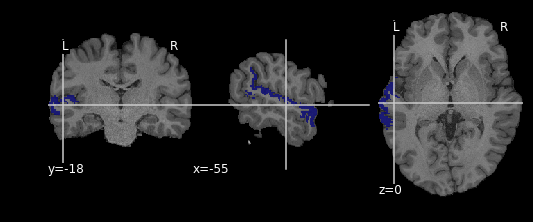

In [29]:
define_region_from_parcellation_to_solver('CTX_LH_G_TEMP_SUP-G_T_TRANSV')
define_region_from_parcellation_to_solver('CTX_LH_G_TEMP_SUP-LATERAL')
define_region_from_parcellation_to_solver('CTX_LH_G_TEMP_SUP-PLAN_POLAR')
define_region_from_parcellation_to_solver('CTX_LH_G_TEMP_SUP-PLAN_TEMPO')


ant_transv_superior_temporal =  region_from_symbol_name(region_solver,'CTX_LH_G_TEMP_SUP-G_T_TRANSV')
lat_superior_temporal = region_from_symbol_name(region_solver,'CTX_LH_G_TEMP_SUP-LATERAL')
planum_polare_superior_temporal =  region_from_symbol_name(region_solver,'CTX_LH_G_TEMP_SUP-PLAN_POLAR')
temp_plane_superior_temporal = region_from_symbol_name(region_solver,'CTX_LH_G_TEMP_SUP-PLAN_TEMPO')

fs = set().union([ant_transv_superior_temporal, lat_superior_temporal, planum_polare_superior_temporal, temp_plane_superior_temporal])
union = region_union(fs, t1w_im.affine)
plotting.plot_roi(union.spatial_image(), t1w_im)

In [ ]:
# superior_temporal = region_from_label(region_solver, 'CTX_RH_S_TEMPORAL_SUP')
# obtained = region_solver.query_relation_region('overlapping', 'CTX_RH_S_TEMPORAL_SUP', 'rh_ovrelap_limit_temp_sup')
# rh_overlap_limit_temp_sup =  region_from_label(region_solver, 'rh_ovrelap_limit_temp_sup')
# fs = set().union([superior_temporal, rh_overlap_limit_temp_sup])
# union = region_union(fs, t1w_im.affine)
# plot_masked_region_from_voxels(t1w_im, union.to_ijk(t1w_im.affine))

In [30]:
region_from_plane = PlanarVolume(origin=(0,0,0), vector=(1,0,0), limit=10)
over_plane_voxels = region_from_plane.to_ijk(t1w_im.affine)
over_plane_voxels
# plotting.plot_roi(i2.spatial_image(), t1w_im, cut_coords=[1, -28, -43]) 
# plot_masked_region_from_voxels(t1w_im, over_plane_voxels, cut_coords=[1, 0, 0])

array([[114, 165,  88],
       [114, 165,  89],
       [114, 165,  90],
       ...,
       [127, 193, 114],
       [127, 193, 115],
       [127, 193, 116]])

In [36]:
plane_args = {'origin': (0,0,0), 'vector': (1,0,0), 'limit': 100}
pdv = get_singleton_element_from_frozenset(query_from_plane(region_solver, 'inferior_from_plane', plane_args, store_into='plane_region'))
from_plane_voxels = pdv.to_ijk(t1w_im.affine)
from_plane_voxels
plotting.plot_roi(pdv.to_explicit_vbr(affine=t1w_im.affine).spatial_image(), t1w_im) 

#plot_masked_region_from_voxels(t1w_im, from_plane_voxels)

IndexError: too many indices for array

In [ ]:
# angular_g = region_from_label(region_solver, 'CTX_RH_G_PARIET_INF-ANGULAR')
# supramarginal_g =  region_from_label(region_solver, 'CTX_RH_G_PARIET_INF-SUPRAMAR')
# temporal_plane_sup_temporal_g = region_from_label(region_solver, 'CTX_RH_G_TEMP_SUP-PLAN_TEMPO')
# posterior_ramus_lateral_s = region_from_label(region_solver, 'CTX_RH_LAT_FIS-POST')
# intermedius_primus_s = region_from_label(region_solver, 'CTX_RH_S_INTERM_PRIM-JENSEN')
# fs = set().union([angular_g, supramarginal_g, temporal_plane_sup_temporal_g, posterior_ramus_lateral_s, intermedius_primus_s])
# rois = region_union(fs, t1w_im.affine)
# plot_masked_region_from_voxels(t1w_im, rois.to_ijk(t1w_im.affine))

In [37]:
# roi_sr = SphericalVolume(union.center, 10)
# plotting.plot_roi(roi_sr.to_ijk(t1w_im.affine).spatial_image(), t1w_im) 
# region_solver.symbol_table[nl.Symbol[region_solver.type]('ROI-SPH')] = nl.Constant[AbstractSet[region_solver.type]](frozenset([roi_sr]))
# obtained = region_solver.query_relation_region('overlapping', 'ROI-SPH')
# print(len(obtained), obtained)

AttributeError: 'numpy.ndarray' object has no attribute 'spatial_image'

### Using the Neurosynth API to define regions

In [ ]:
neurosynth_im = nib.load('/home/mschmit/Documents/python/emotion/pAgF_z_FDR_0.01.nii.gz')
region_voxels = neurosynth_im.get_data().nonzero()
print(neurosynth_im)

In [ ]:
roi_voxels = np.array(list(zip(*(region_voxels))))
ns_emotion_region = ExplicitVBR(roi_voxels, t1w_im.affine)
plotting.plot_roi(roi_sr.to_ijk(ns_emotion_region.spatial_image(), t1w_im) 
#plot_masked_region_from_voxels(neurosynth_im, roi_voxels)
len(ns_emotion_region.voxels)

In [ ]:
# Core functionality for managing and accessing data
from neurosynth import Dataset
# Analysis tools for meta-analysis, image decoding, and coactivation analysis
from neurosynth import meta, decode, network

dataset = Dataset.load('../neurolang/utils/neurosynth/dataset.pkl')   # Note the capital D in the second Dataset--load() is a class method
ids = dataset.get_studies(features='parietal lobe', frequency_threshold=0.05)
ma = meta.MetaAnalysis(dataset, ids, q=0.01, prior=0.5)
data = ma.images['pAgF_z_FDR_0.01']
affine = dataset.masker.get_header().get_sform() #affine

In [ ]:
brain_map = dataset.masker.unmask(data)

from scipy.ndimage import label, generate_binary_structure
s = generate_binary_structure(3,1)
labeled_array, num_features = label(brain_map, structure=s)

In [ ]:
emotion_regions = []
for i in range(num_features):
    voxels = list(zip(*np.where(labeled_array == i)))
    emotion_regions.append(ExplicitVBR(voxels,affine))

In [ ]:
dataset.masker.unmask(data)[12,:,:].shape

In [ ]:
emotion_regions = sorted(emotion_regions, key= lambda x: len(x.voxels), reverse=True)

In [ ]:
define_region_from_parcellation_to_solver('CTX_RH_S_FRONT_MIDDLE')
temporal_region = region_solver.load_term_defined_regions('temporal lobe', k=2)
next(iter(temporal_region)).bounding_box

In [ ]:
obtained = region_solver.query_relation_region('anterior_of', 'TEMPORAL LOBE')
print(len(obtained), obtained)